In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix,mean_absolute_error 
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Obesity prediction.csv')

In [3]:
df.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   object 
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   object 
 5   FAVC            2111 non-null   object 
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   object 
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   object 
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  Obesity         2111 non-null   object 
dtypes: float64(8), object(9)
memory u

In [5]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [6]:
df.describe(include = "object")

,Gender,family_history,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,Obesity
count,2111,2111,2111,2111,2111,2111,2111,2111,2111
unique,2,2,2,4,2,2,4,5,7
top,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_I
freq,1068,1726,1866,1765,2067,2015,1401,1580,351


# Data Details:

Gender: Gender

Age: Age

Height : in metres

Weight : in kgs

family_history : Has a family member suffered or suffers from overweight?

FAVC : Do you eat high caloric food frequently?

FCVC : Do you usually eat vegetables in your meals?

NCP : How many main meals do you have daily?

CAEC : Do you eat any food between meals?

SMOKE : Do you smoke?

CH2O : How much water do you drink daily?

SCC : Do you monitor the calories you eat daily?

FAF: How often do you have physical activity?

TUE : How much time do you use technological devices such as cell phone, videogames, television, computer and others?

CALC : How often do you drink alcohol?

MTRANS : Which transportation do you usually use?

Obesity_level (Target Column) : Obesity level

In [7]:
# How many values in categorical features
cat_cols = []
for col in df.columns:
    if df[col].dtypes == "object":
        cat_cols.append(col)

for i in cat_cols:
    print(df[i].value_counts())
    print("-"*30)

Gender
Male      1068
Female    1043
Name: count, dtype: int64
------------------------------
family_history
yes    1726
no      385
Name: count, dtype: int64
------------------------------
FAVC
yes    1866
no      245
Name: count, dtype: int64
------------------------------
CAEC
Sometimes     1765
Frequently     242
Always          53
no              51
Name: count, dtype: int64
------------------------------
SMOKE
no     2067
yes      44
Name: count, dtype: int64
------------------------------
SCC
no     2015
yes      96
Name: count, dtype: int64
------------------------------
CALC
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64
------------------------------
MTRANS
Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: count, dtype: int64
------------------------------
Obesity
Obesity_Type_I         351
Obesity_Type_III       324


# EXPLORATORY DATA ANALYSIS

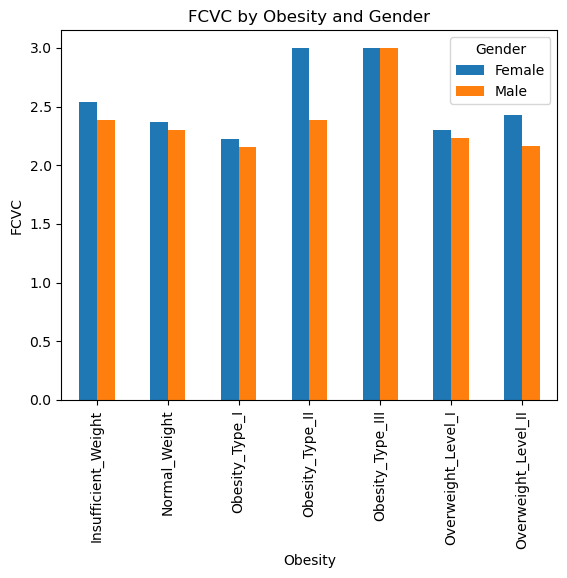

In [8]:
pivot_data = df.pivot_table(index="Obesity", columns="Gender", values="FCVC", aggfunc="mean")  
pivot_data.plot(kind="bar")  
plt.xlabel("Obesity")  
plt.ylabel("FCVC")  
plt.title("FCVC by Obesity and Gender")  
plt.legend(title="Gender")  
plt.show()

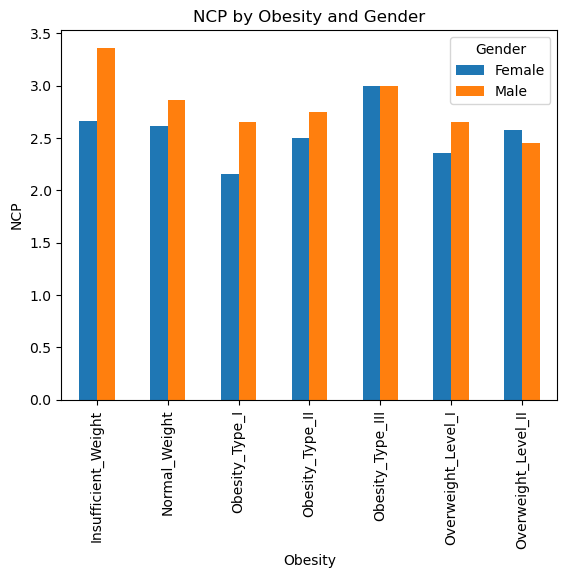

In [9]:
pivot_data = df.pivot_table(index="Obesity", columns="Gender", values="NCP", aggfunc="mean")  
pivot_data.plot(kind="bar")  
plt.xlabel("Obesity")  
plt.ylabel("NCP")  
plt.title("NCP by Obesity and Gender")  
plt.legend(title="Gender")  
plt.show()

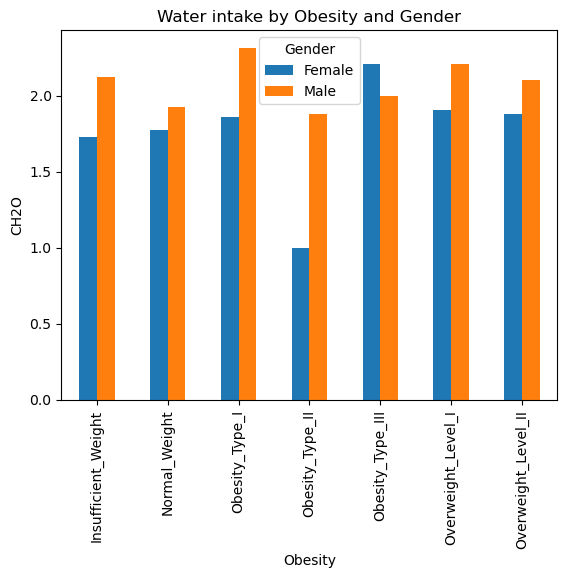

In [10]:
pivot_data = df.pivot_table(index="Obesity", columns="Gender", values="CH2O", aggfunc="mean")  
pivot_data.plot(kind="bar")  
plt.xlabel("Obesity")  
plt.ylabel("CH2O")  
plt.title("Water intake by Obesity and Gender")  
plt.legend(title="Gender")  
plt.show()

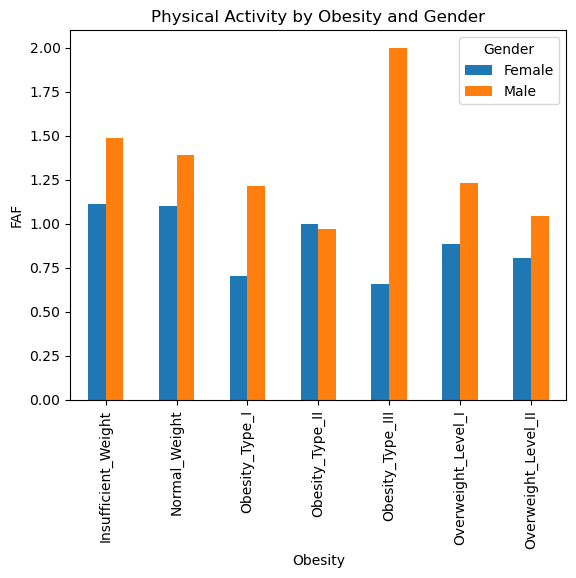

In [11]:
pivot_data = df.pivot_table(index="Obesity", columns="Gender", values="FAF", aggfunc="mean")  
pivot_data.plot(kind="bar")  
plt.xlabel("Obesity")  
plt.ylabel("FAF")  
plt.title("Physical Activity by Obesity and Gender")  
plt.legend(title="Gender")  
plt.show()

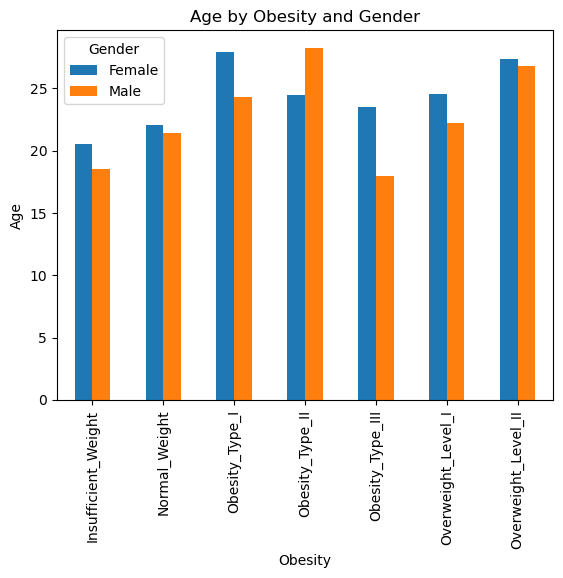

In [12]:
pivot_data = df.pivot_table(index="Obesity", columns="Gender", values="Age", aggfunc="mean")  
pivot_data.plot(kind="bar")  
plt.xlabel("Obesity")  
plt.ylabel("Age")  
plt.title("Age by Obesity and Gender")  
plt.legend(title="Gender")  
plt.show()

In [13]:
y = df['Obesity']  # Replace with actual target column name
le = LabelEncoder()
labels = {}
y_encoded = le.fit_transform(y)
labels[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [14]:
labels[col]

{'Insufficient_Weight': 0,
 'Normal_Weight': 1,
 'Obesity_Type_I': 2,
 'Obesity_Type_II': 3,
 'Obesity_Type_III': 4,
 'Overweight_Level_I': 5,
 'Overweight_Level_II': 6}

In [15]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define column categories
ordinal_cols = ["CAEC", "CALC"]  # Ordinal categorical features
nominal_cols = ["Gender", "MTRANS", "FAVC", "family_history", "SMOKE", "SCC"]  # Nominal categorical features
numerical_cols = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]  # Numerical features

# Define ordinal categories mapping
ordinal_categories = {
    "CAEC": ["no", "Sometimes", "Frequently", "Always"],
    "CALC": ["no", "Sometimes", "Frequently", "Always"]
}

X = df.drop("Obesity", axis=1)

# Store ordinal encoding mappings
ordinal_encoders = {col: {category: i for i, category in enumerate(ordinal_categories[col])} for col in ordinal_cols}

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ("num", "passthrough", numerical_cols),  # Numerical features
    ("ord", OrdinalEncoder(categories=[ordinal_categories[col] for col in ordinal_cols]), ordinal_cols),  # Ordinal encoding
    ("nom", OneHotEncoder(drop="first"), nominal_cols)  # One-Hot encoding (drop first category to avoid multicollinearity)
])

# Apply transformations
X_processed = preprocessor.fit_transform(X)

# Get encoded feature names
encoded_nominal_names = list(preprocessor.named_transformers_["nom"].get_feature_names_out(nominal_cols))
encoded_feature_names = numerical_cols + ordinal_cols + encoded_nominal_names

# Convert to DataFrame
X_encoded = pd.DataFrame(X_processed, columns=encoded_feature_names)

# Store the mapping for reference
encoding_info = {
    "ordinal_mappings": ordinal_encoders,
    "one_hot_categories": {col: list(preprocessor.named_transformers_["nom"].categories_[i]) for i, col in enumerate(nominal_cols)},
    "encoded_feature_names": encoded_feature_names
}

# Print encoding mappings for reference
print(" Ordinal Encoding Mappings:")
for col, mapping in ordinal_encoders.items():
    print(f"{col}: {mapping}")

print("\n One-Hot Encoded Categories:")
for col, categories in encoding_info["one_hot_categories"].items():
    print(f"{col}: {categories}")

# Show final processed dataset
print("\n Encoded DataFrame:")
print(X_encoded.head())


 Ordinal Encoding Mappings:
CAEC: {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
CALC: {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}

 One-Hot Encoded Categories:
Gender: ['Female', 'Male']
MTRANS: ['Automobile', 'Bike', 'Motorbike', 'Public_Transportation', 'Walking']
FAVC: ['no', 'yes']
family_history: ['no', 'yes']
SMOKE: ['no', 'yes']
SCC: ['no', 'yes']

 Encoded DataFrame:
    Age  Height  Weight  FCVC  NCP  CH2O  FAF  TUE  CAEC  CALC  Gender_Male  \
0  21.0    1.62    64.0   2.0  3.0   2.0  0.0  1.0   1.0   0.0          0.0   
1  21.0    1.52    56.0   3.0  3.0   3.0  3.0  0.0   1.0   1.0          0.0   
2  23.0    1.80    77.0   2.0  3.0   2.0  2.0  1.0   1.0   2.0          1.0   
3  27.0    1.80    87.0   3.0  3.0   2.0  2.0  0.0   1.0   2.0          1.0   
4  22.0    1.78    89.8   2.0  1.0   2.0  0.0  0.0   1.0   1.0          1.0   

   MTRANS_Bike  MTRANS_Motorbike  MTRANS_Public_Transportation  \
0          0.0               0.0                           

### X_encoded.head()

In [17]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           2111 non-null   float64
 1   Height                        2111 non-null   float64
 2   Weight                        2111 non-null   float64
 3   FCVC                          2111 non-null   float64
 4   NCP                           2111 non-null   float64
 5   CH2O                          2111 non-null   float64
 6   FAF                           2111 non-null   float64
 7   TUE                           2111 non-null   float64
 8   CAEC                          2111 non-null   float64
 9   CALC                          2111 non-null   float64
 10  Gender_Male                   2111 non-null   float64
 11  MTRANS_Bike                   2111 non-null   float64
 12  MTRANS_Motorbike              2111 non-null   float64
 13  MTR

In [18]:
X_encoded.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,CAEC,CALC,Gender_Male,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,FAVC_yes,family_history_yes,SMOKE_yes,SCC_yes
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866,1.140692,0.731407,0.505921,0.003316,0.005211,0.748460,0.026528,0.883941,0.817622,0.020843,0.045476
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927,0.468543,0.515498,0.500083,0.057502,0.072015,0.434001,0.160737,0.320371,0.386247,0.142893,0.208395
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Prepare and Build ML model

In [19]:
print(y_encoded)

[1 1 1 ... 4 4 4]


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=60
)

In [21]:
model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    random_state=42,
    n_jobs=-1
)

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

In [22]:
# Randomized search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on Test Data
y_pred = best_model.predict(X_test)

# Calculate Accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f" Test Accuracy: {test_accuracy:.4f}")


 Test Accuracy: 0.9693



 Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       0.96      0.95      0.96        58
           2       0.97      0.94      0.96        70
           3       0.98      1.00      0.99        60
           4       1.00      0.98      0.99        65
           5       0.92      0.95      0.93        58
           6       0.97      0.97      0.97        58

    accuracy                           0.97       423
   macro avg       0.97      0.97      0.97       423
weighted avg       0.97      0.97      0.97       423



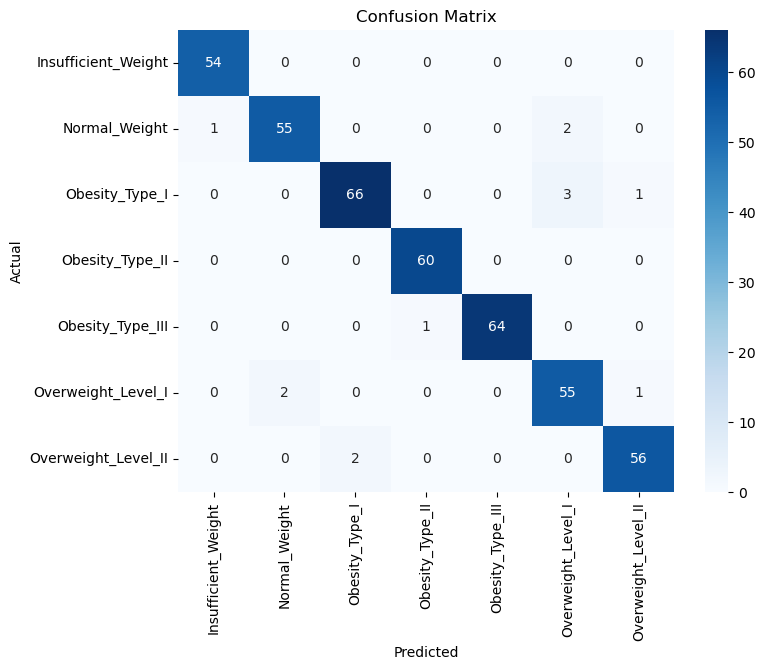

In [24]:
# Print Classification Report
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

#  Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [25]:
print("MAE Score :", mean_absolute_error(y_pred, y_test))

MAE Score : 0.09456264775413711


In [26]:
import joblib

joblib.dump(best_model, "model.pkl")

print(" Model saved as model.pkl")


 Model saved as model.pkl


In [27]:
import joblib
import numpy as np

# Load the trained model
model = joblib.load("model.pkl")  


X_new = np.array([[21.0, 1.62, 64.0, 2.0, 3.0, 2.0, 0.0, 1.0, 1.0, 0.0, 
                   0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]])

# Make prediction
y_pred = model.predict(X_new)

print(" Predicted Class:", y_pred)


 Predicted Class: [1]


In [28]:

X_new = np.array([[23.361936, 1.739450, 133.346641, 3.0, 3.0, 2.852339, 1.139107, 
                   0.58605, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0]])


y_pred = model.predict(X_new)

print(" Predicted Class:", y_pred)  # Output the predicted category


 Predicted Class: [4]
